#Load libraries & data

In [ ]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.models import Sequential
from keras.layers import  GRU, Bidirectional,  SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

%matplotlib inline

!pip install ipython-autotime
%load_ext autotime

time: 134 µs


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Fake-vs-real/all_complete_labelled/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 6.44 ms


In [ ]:
df = pd.read_csv(root_path + "combined-1.csv", names = ['label','text','fullname','replies','retweet','likes'], skiprows=1)
#df = pd.read_csv(root_path + "ক্যান্সার-first-1000-stemmed.csv",names=['label','text'])

#df.drop(df.columns[[2,3,4,5,6,7]],axis = 1,inplace = True)
df.shape


(2067, 6)

time: 1.68 s


In [ ]:
df.head()

,label,text,fullname,replies,retweet,likes
0,FAKE,ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...,NaN,NaN,NaN,NaN
1,REAL,মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ\n#ইত...,NaN,NaN,NaN,NaN
2,REAL,যাদের বয়স এবং লম্বা হিসাবের চেয়ে \nওজন বেশি ...,NaN,NaN,NaN,NaN
3,REAL,ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন,NaN,NaN,NaN,NaN
4,REAL,"হৃদরোগ, ডায়াবেটিস, শ্বাসতন্ত্রের রোগ এবং হাইপ...",NaN,NaN,NaN,NaN


time: 36.5 ms


In [ ]:
df.drop(df.columns[[2,3,4,5]],axis=1, inplace=True)

In [ ]:
df.head()

,label,text
0,FAKE,ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...
1,REAL,মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ\n#ইত...
2,REAL,যাদের বয়স এবং লম্বা হিসাবের চেয়ে \nওজন বেশি ...
3,REAL,ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন
4,REAL,"হৃদরোগ, ডায়াবেটিস, শ্বাসতন্ত্রের রোগ এবং হাইপ..."


time: 11.3 ms


In [ ]:
df['target'] = df['label']

time: 2.84 ms


(array([320., 904.,  35.,   0., 297., 109.,   0.,  82.,  25., 295.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

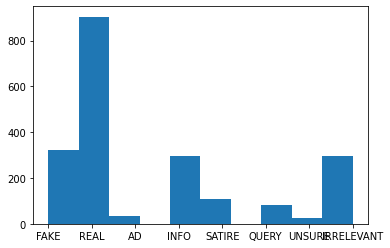

time: 215 ms


In [ ]:
plt.hist(df['target'])

#Pre processing steps

The function does the following:

* It replaces common texts found in the data and replaces that with our custom text
* It removes all emoji's and emoticons from the text
* It removes all English text

In [ ]:
import re
def replace_strings(texts, replace):
    new_texts=[]
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    
    regex = r'\b(?:(?:[0-9\u09E6-\u09EF]{1,2}[:/,.]){2}[0-9\u09E6-\u09EF]{2,4}|am|pm)\b'
    for text in texts:
        for r in replace:
            text=text.replace(r[0], r[1])

        text=emoji_pattern.sub(r'', text)
        text=english_pattern.sub(r'', text)
  
        if re.search(regex, text): # re.match() e pura string replace kore fele
          text = re.sub(regex, "<date>", text)
        
        #text = re.sub(r'[-!?]','',text)
        text=re.sub(r'\s+', ' ', text).strip()
        text = text.replace("\"","")
        text = text.replace(".","")
        new_texts.append(text)

    return new_texts

In [ ]:
#my_str = ["কথা_জমিয়ে '" "রাখতে নেই\nআত্নার ক্যান্সার। হয়?","আত্নার ক্যান্সার হয়"]

replace=[('\u200c', ' '),
         ('\u200d', ' '),
        ('\xa0', ' '),
        ('\n', ' '),
        ('\r', ' '),('&',''),('*',''),
         ('\"',' '),
         ('_',' '),
         ('?',' '),
         ('!',' '),
         ('।',' '),
         ('|',' '),
         ('#',' '),
         ('%',' '),
         ('/',' '),
         ('-',' '),
         (':',' '),
         ('<',' '),
         ('>',' '),
         ('(',' '),
         (')',' '),
         ('—',' '),
         ("'",' '),
         (',',' '),
         (';',' '),
         ('\\',' '),
         ('~',' '),
         ('”',''),
         ('•',' '),
         ('[',' '),
         (']',' '),
         ('{',' '),
         ('}',' '),
         ('“',' '),
         ('’',' '),
         ('‘',' ')
         ]

#new_str =replace_strings(my_str, replace)
df.text = replace_strings(df.text, replace)
#print(new_str)

In [ ]:
df.text[:5]

0    ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...
1    মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ ইত্ত...
2    যাদের বয়স এবং লম্বা হিসাবের চেয়ে ওজন বেশি তা...
3               ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন
4    হৃদরোগ ডায়াবেটিস শ্বাসতন্ত্রের রোগ এবং হাইপার...
Name: text, dtype: object

In [ ]:
# goal - remove whitespace

import string
df.text = df.text.str.strip()

In [ ]:
df.head()

,label,text,target
0,FAKE,ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে ওষুধ...,FAKE
1,REAL,মায়ের ডায়াবেটিসে নবজাতকের ঝুঁকি দ্বিগুণ ইত্ত...,REAL
2,REAL,যাদের বয়স এবং লম্বা হিসাবের চেয়ে ওজন বেশি তা...,REAL
3,REAL,ডায়াবেটিস রোগীরা কেন ঝুঁকিতে জেনে নিন,REAL
4,REAL,হৃদরোগ ডায়াবেটিস শ্বাসতন্ত্রের রোগ এবং হাইপার...,REAL


In [ ]:
#------------------------------
# A list of bangla stop words found from https://github.com/stopwords-iso/stopwords-bn/blob/master/stopwords-bn.json
#------------------------------

bn_stop_words = frozenset(["via","অতএব","অথচ","অথবা","অনুযায়ী","অনেক","অনেকে","অনেকেই","অন্তত","অন্য","অবধি","অবশ্য","অর্থাত","আই","আগামী","আগে","আগেই","আছে","আজ","আদ্যভাগে","আপনার","আপনি","আবার","আমরা","আমাকে","আমাদের","আমার","আমি","আর","আরও","ই","ইত্যাদি","ইহা","উচিত","উত্তর","উনি","উপর","উপরে","এ","এঁদের","এঁরা","এই","একই","একটি","একবার","একে","এক্","এখন","এখনও","এখানে","এখানেই","এটা","এটাই","এটি","এত","এতটাই","এতে","এদের","এব","এবং","এবার","এমন","এমনকী","এমনি","এর","এরা","এল","এস","এসে","ঐ","ও","ওঁদের","ওঁর","ওঁরা","ওই","ওকে","ওখানে","ওদের","ওর","ওরা","কখনও","কত","কবে","কমনে","কয়েক","কয়েকটি","করছে","করছেন","করতে","করবে","করবেন","করলে","করলেন","করা","করাই","করায়","করার","করি","করিতে","করিয়া","করিয়ে","করে","করেই","করেছিলেন","করেছে","করেছেন","করেন","কাউকে","কাছ","কাছে","কাজ","কাজে","কারও","কারণ","কি","কিংবা","কিছু","কিছুই","কিন্তু","কী","কে","কেউ","কেউই","কেখা","কেন","কোটি","কোন","কোনও","কোনো","ক্ষেত্রে","কয়েক","খুব","গিয়ে","গিয়েছে","গিয়ে","গুলি","গেছে","গেল","গেলে","গোটা","চলে","চান","চায়","চার","চালু","চেয়ে","চেষ্টা","ছাড়া","ছাড়াও","ছিল","ছিলেন","জন","জনকে","জনের","জন্য","জন্যওজে","জানতে","জানা","জানানো","জানায়","জানিয়ে","জানিয়েছে","জে","জ্নজন","টি","ঠিক","তখন","তত","তথা","তবু","তবে","তা","তাঁকে","তাঁদের","তাঁর","তাঁরা","তাঁাহারা","তাই","তাও","তাকে","তাতে","তাদের","তার","তারপর","তারা","তারৈ","তাহলে","তাহা","তাহাতে","তাহার","তিনঐ","তিনি","তিনিও","তুমি","তুলে","তেমন","তো","তোমার","থাকবে","থাকবেন","থাকা","থাকায়","থাকে","থাকেন","থেকে","থেকেই","থেকেও","দিকে","দিতে","দিন","দিয়ে","দিয়েছে","দিয়েছেন","দিলেন","দু","দুই","দুটি","দুটো","দেওয়া","দেওয়ার","দেওয়া","দেখতে","দেখা","দেখে","দেন","দেয়","দ্বারা","ধরা","ধরে","ধামার","নতুন","নয়","না","নাই","নাকি","নাগাদ","নানা","নিজে","নিজেই","নিজেদের","নিজের","নিতে","নিয়ে","নিয়ে","নেই","নেওয়া","নেওয়ার","নেওয়া","নয়","পক্ষে","পর","পরে","পরেই","পরেও","পর্যন্ত","পাওয়া","পাচ","পারি","পারে","পারেন","পি","পেয়ে","পেয়্র্","প্রতি","প্রথম","প্রভৃতি","প্রযন্ত","প্রাথমিক","প্রায়","প্রায়","ফলে","ফিরে","ফের","বক্তব্য","বদলে","বন","বরং","বলতে","বলল","বললেন","বলা","বলে","বলেছেন","বলেন","বসে","বহু","বা","বাদে","বার","বি","বিনা","বিভিন্ন","বিশেষ","বিষয়টি","বেশ","বেশি","ব্যবহার","ব্যাপারে","ভাবে","ভাবেই","মতো","মতোই","মধ্যভাগে","মধ্যে","মধ্যেই","মধ্যেও","মনে","মাত্র","মাধ্যমে","মোট","মোটেই","যখন","যত","যতটা","যথেষ্ট","যদি","যদিও","যা","যাঁর","যাঁরা","যাওয়া","যাওয়ার","যাওয়া","যাকে","যাচ্ছে","যাতে","যাদের","যান","যাবে","যায়","যার","যারা","যিনি","যে","যেখানে","যেতে","যেন","যেমন","র","রকম","রয়েছে","রাখা","রেখে","লক্ষ","শুধু","শুরু","সঙ্গে","সঙ্গেও","সব","সবার","সমস্ত","সম্প্রতি","সহ","সহিত","সাধারণ","সামনে","সি","সুতরাং","সে","সেই","সেখান","সেখানে","সেটা","সেটাই","সেটাও","সেটি","স্পষ্ট","স্বয়ং","হইতে","হইবে","হইয়া","হওয়া","হওয়ায়","হওয়ার","হচ্ছে","হত","হতে","হতেই","হন","হবে","হবেন","হয়","হয়তো","হয়নি","হয়ে","হয়েই","হয়েছিল","হয়েছে","হয়েছেন","হল","হলে","হলেই","হলেও","হলো","হাজার","হিসাবে","হৈলে","হোক","হয়"])

#train test split

In [ ]:
# train_text, test_text, train_y, test_y = train_test_split(df['text'],df['target'],test_size = 0.0001)
train_text, test_text, train_y, test_y = train_test_split(df['text'],df['target'],test_size = 0.3)

In [ ]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
txt = ["ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে","ডায়াবেটিস রুগীদের ডায়াবেটিস থেকে কিভাবে"]
seq = list(tokenizer.texts_to_sequences_generator(txt))

In [ ]:
seq

[[4, 4940, 4, 11, 231], [4, 4940, 4, 11, 231]]

In [ ]:
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5713 unique tokens.


In [ ]:
word_index

{'ক্যান্সার': 1,
 'উপায়': 2,
 'ঘরোয়া': 3,
 'ডায়াবেটিস': 4,
 'ও': 5,
 'হয়': 6,
 'না': 7,
 'কি': 8,
 'করার': 9,
 'জন্য': 10,
 'থেকে': 11,
 'করে': 12,
 'দূর': 13,
 'এই': 14,
 'আক্রান্ত': 15,
 'পারে': 16,
 'বা': 17,
 'হবে': 18,
 'করুন': 19,
 'রক্ত': 20,
 'এর': 21,
 'উপকার': 22,
 'মাত্র': 23,
 'হাসপাতাল': 24,
 'করতে': 25,
 'জেনে': 26,
 'এবং': 27,
 'কিছু': 28,
 'এ': 29,
 'নিন': 30,
 'রোগীর': 31,
 'করা': 32,
 'সমস্যা': 33,
 'একজন': 34,
 '১': 35,
 'চিকিৎসা': 36,
 'টি': 37,
 'খেলে': 38,
 'আর': 39,
 'আমাদের': 40,
 'একটি': 41,
 'দিতে': 42,
 'নিয়ে': 43,
 'সহজ': 44,
 'বেশি': 45,
 'এগিয়ে': 46,
 'কেউ': 47,
 'রোগ': 48,
 'হয়ে': 49,
 'ব্যাগ': 50,
 'ব্যথা': 51,
 'এক': 52,
 'শেয়ার': 53,
 'যায়': 54,
 '১০': 55,
 'যোগাযোগ': 56,
 'কালো': 57,
 'আছে': 58,
 'অন্য': 59,
 'হতে': 60,
 'স্থান': 61,
 'অনেক': 62,
 'যে': 63,
 'যেন': 64,
 'দিনে': 65,
 'মধ্যে': 66,
 'দরকার': 67,
 'পারলেও': 68,
 'আপনার': 69,
 'ভালো': 70,
 'হলে': 71,
 'রোগীদের': 72,
 'তার': 73,
 'আমি': 74,
 'মা': 75,
 'স্তন': 76,
 'সব': 77,
 '৫': 

In [ ]:
sequences[0]

[175, 211, 32, 93, 692, 180, 497, 157, 1, 5, 2374, 158, 181, 2375, 1102, 498]

In [ ]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 5713)

In [ ]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [ ]:
" ".join([index_to_word[i] for i in sequences[0]])

'ওজন কম করা ব্লাড সুগার রক্তচাপ কোলেস্টেরল নিয়ন্ত্রণ ক্যান্সার ও আর্থাইট্রিস রোগের প্রতিরোধে অলিভ বেশ উপকারী'

In [ ]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 15.8
max length: 55


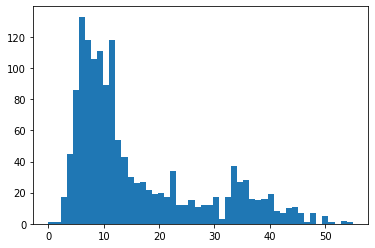

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

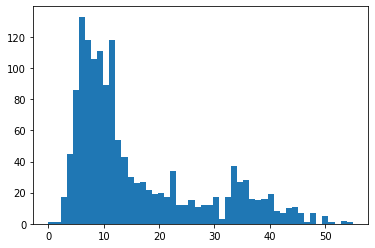

In [ ]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [ ]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (1446, 150)
Shape of data test tensor: (621, 150)


In [ ]:
df['label'].value_counts()

REAL          904
FAKE          320
INFO          297
IRRELEVANT    295
SATIRE        109
QUERY          82
AD             35
UNSURE         25
Name: label, dtype: int64

In [ ]:
y_train = train_y
y_test = test_y

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
# y_train.dtypes
y_train = to_categorical(np.asarray(y_train.factorize()[0]))
y_test = to_categorical(np.asarray(y_test.factorize()[0]))

In [ ]:
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (1446, 8)


#A simple supervised CBOW model in Keras

In [ ]:
EMBEDDING_DIM = 50
N_CLASSES = 8

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
# model.fit(x_train, y_train, validation_split=0.1,
#           epochs=1000, batch_size=128)

In [ ]:
my_model = model.fit(x_train, y_train, validation_split=0.2,
          epochs=500, batch_size=128)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1652 samples, validate on 414 samples
Epoch 1/500
1652/1652 [==============================] - 0s 246us/step - loss: 2.0641 - acc: 0.2185 - val_loss: 2.0292 - val_acc: 0.4420
Epoch 2/500
1652/1652 [==============================] - 0s 55us/step - loss: 2.0057 - acc: 0.4358 - val_loss: 1.9713 - val_acc: 0.4420
Epoch 3/500
1652/1652 [==============================] - 0s 57us/step - loss: 1.9493 - acc: 0.4358 - val_loss: 1.9125 - val_acc: 0.4420
Epoch 4/500
1652/1652 [==============================] - 0s 56us/step - loss: 1.8898 - acc: 0.4358 - val_loss: 1.8525 - val_acc: 0.4420
Epoch 5/500
1652/1652 [==============================] - 0s 55us/step - loss: 1.8301 - acc: 0.4358 - val_loss: 1.7902 - val_acc: 0.4420
Epoch 6/500
1652/1652 [==============================] - 0s 54us/step - loss: 1.7702 - acc: 0.4358 - val_loss: 1.7297 - val_acc: 0.4420
Epoch 7/500
1652/1652 [==============================] - 0s 63us/step - loss: 1.7156 - acc: 0.4358 - val_loss: 1.6758 - val_acc: 0.4420


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 408       
Total params: 1,000,408
Trainable params: 1,000,408
Non-trainable params: 0
_________________________________________________________________


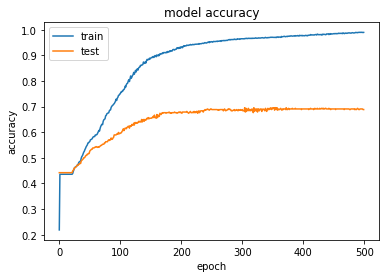

In [ ]:
# summarize history for accuracy
plt.plot(my_model.history['acc'])
plt.plot(my_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#max accuracy 
print("Max acc from training set %0.5f" % max(my_model.history['acc']))
print("Max val_acc from validation set %0.5f" % max(my_model.history['val_acc']))

Max acc from training set 0.99031
Max val_acc from validation set 0.69565


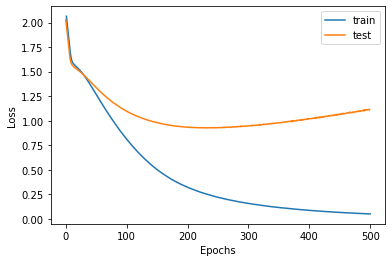

In [ ]:
# summarize history for loss
loss_values = my_model.history['loss']
val_loss = my_model.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.show()



In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred


array([[4.6804086e-03, 1.7654649e-03, 9.3680644e-01, 8.4815118e-03,
        6.4985310e-05, 4.7356497e-02, 1.0628646e-04, 7.3845353e-04]],
      dtype=float32)

In [ ]:
y_test = to_categorical(np.asarray(y_test.factorize()[0]))

In [ ]:
y_test

#A complex model : LSTM

In [ ]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
lstm_model = model.fit(x_train, y_train, validation_split=0.3,
          epochs=100, batch_size=128)

In [ ]:
model.summary()

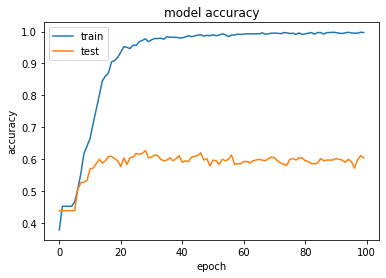

In [ ]:
# summarize history for accuracy
plt.plot(lstm_model.history['acc'])
plt.plot(lstm_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#max accuracy 
print("Max acc from training set %0.5f" % max(lstm_model.history['acc']))
print("Max val_acc from validation set %0.5f" % max(lstm_model.history['val_acc']))

Max acc from training set 0.99802
Max val_acc from validation set 0.62673


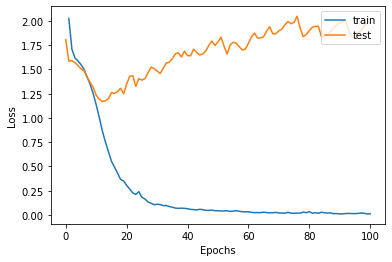

In [ ]:
# summarize history for loss
loss_values = lstm_model.history['loss']
val_loss = lstm_model.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.show()



In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred.shape
lstm_model

(621, 8)

In [ ]:
y_test = to_categorical(np.asarray(y_test.factorize()[0]))

In [ ]:
y_test.shape

(621, 8)

In [ ]:
print("test roc_auc_score %0.4f" %roc_auc_score(y_test,y_pred))

test roc_auc_score 0.6030


#GRU model

In [ ]:
# count number of unique words
vocabulary_size = len(tokenizer.word_index) + 1

In [ ]:

model = Sequential()
model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

In [ ]:

# history = model.fit(x_train, y_train, epochs=5, batch_size=128, callbacks=[callback])

# gru_model = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=128, callbacks=[callback]) #ami validation data alada kore dichi

gru_model = model.fit(x_train, y_train, epochs=50,validation_split=0.3, batch_size=128) #train data'r 30% niye validate kore


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1446 samples, validate on 620 samples
Epoch 1/50
1446/1446 [==============================] - 11s 8ms/step - loss: 0.1059 - accuracy: 0.3983 - val_loss: 0.0956 - val_accuracy: 0.4565
Epoch 2/50
1446/1446 [==============================] - 8s 6ms/step - loss: 0.0930 - accuracy: 0.4288 - val_loss: 0.0887 - val_accuracy: 0.4565
Epoch 3/50
1446/1446 [==============================] - 8s 6ms/step - loss: 0.0862 - accuracy: 0.4288 - val_loss: 0.0810 - val_accuracy: 0.4774
Epoch 4/50
1446/1446 [==============================] - 8s 6ms/step - loss: 0.0764 - accuracy: 0.5256 - val_loss: 0.0767 - val_accuracy: 0.5177
Epoch 5/50
1446/1446 [==============================] - 8s 6ms/step - loss: 0.0676 - accuracy: 0.5726 - val_loss: 0.0726 - val_accuracy: 0.5468
Epoch 6/50
1446/1446 [==============================] - 8s 6ms/step - loss: 0.0590 - accuracy: 0.6328 - val_loss: 0.0730 - val_accuracy: 0.5565
Epoch 7/50
1446/1446 [==============================] - 8s 6ms/step - loss: 0.0503 - acc

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           354400    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               137472    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 525,800
Trainable params: 525,800
Non-trainable params: 0
________________________________________________

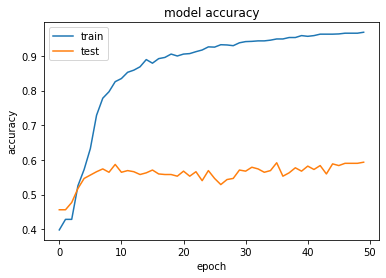

In [ ]:
# summarize history for accuracy
plt.plot(gru_model.history['accuracy'])
plt.plot(gru_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#max accuracy 
print("Max acc from training set %0.5f" % max(gru_model.history['accuracy']))
print("Max val_acc from validation set %0.5f" % max(gru_model.history['val_accuracy']))

Max acc from training set 0.96819
Max val_acc from validation set 0.59355


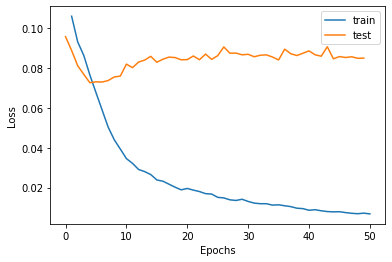

In [ ]:
# summarize history for loss
loss_values = gru_model.history['loss']
val_loss = gru_model.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.show()



In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred.shape


(621, 8)

In [ ]:
y_test = to_categorical(np.asarray(y_test.factorize()[0]))

In [ ]:
y_test.shape

(621, 8)

In [ ]:
print("test roc_auc_score %0.4f" %roc_auc_score(y_test,y_pred))

test roc_auc_score 0.5330


#Bi-LSTM

In [ ]:
# count number of unique words
vocabulary_size = len(tokenizer.word_index) + 1

In [ ]:
model = Sequential()

model.add( Embedding(vocabulary_size, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add( Bidirectional( LSTM(196, dropout = 0.2, recurrent_dropout = 0.2)))
model.add( Dense(8, activation = 'softmax'))

# Sparse cross entropy is used when your output is an integer like 0,1,2,3,..13. But your output is onehot encoded [0,0,...1,0].

# So use categorical cross entropy.
# or do model.add( Dense(1, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])



In [ ]:
# bi_lstm = model.fit(x_train, y_train, epochs = 7, batch_size = 128, verbose = 2)
bi_lstm = model.fit(x_train, y_train, epochs=100,validation_split=0.3, batch_size=128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1446 samples, validate on 620 samples
Epoch 1/100
1446/1446 [==============================] - 12s 8ms/step - loss: 1.8959 - accuracy: 0.3907 - val_loss: 1.6885 - val_accuracy: 0.4565
Epoch 2/100
1446/1446 [==============================] - 11s 8ms/step - loss: 1.6595 - accuracy: 0.4288 - val_loss: 1.5676 - val_accuracy: 0.4565
Epoch 3/100
1446/1446 [==============================] - 11s 8ms/step - loss: 1.6151 - accuracy: 0.4288 - val_loss: 1.5316 - val_accuracy: 0.4565
Epoch 4/100
1446/1446 [==============================] - 11s 8ms/step - loss: 1.5364 - accuracy: 0.4329 - val_loss: 1.4385 - val_accuracy: 0.4613
Epoch 5/100
1446/1446 [==============================] - 11s 7ms/step - loss: 1.4145 - accuracy: 0.5014 - val_loss: 1.3563 - val_accuracy: 0.5016
Epoch 6/100
1446/1446 [==============================] - 11s 8ms/step - loss: 1.2725 - accuracy: 0.5671 - val_loss: 1.2896 - val_accuracy: 0.5500
Epoch 7/100
1446/1446 [==============================] - 11s 8ms/step - loss:

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           354400    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 392)               387296    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 3144      
Total params: 744,840
Trainable params: 744,840
Non-trainable params: 0
_________________________________________________________________


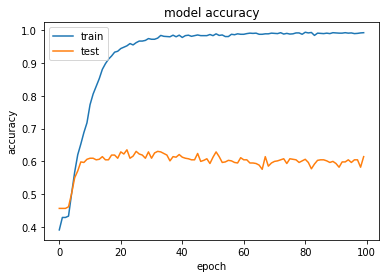

In [ ]:
# summarize history for accuracy
plt.plot(bi_lstm.history['accuracy'])
plt.plot(bi_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#max accuracy 
print("Max acc from training set %0.5f" % max(bi_lstm.history['accuracy']))
print("Max val_acc from validation set %0.5f" % max(bi_lstm.history['val_accuracy']))

Max acc from training set 0.99447
Max val_acc from validation set 0.63548


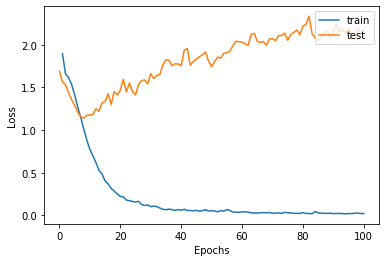

In [ ]:
# summarize history for loss
loss_values = bi_lstm.history['loss']
val_loss = bi_lstm.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

plt.show()



In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred.shape


(621, 8)

In [ ]:
y_test = to_categorical(np.asarray(y_test.factorize()[0]))

In [ ]:
y_test.shape

(621, 8)

In [ ]:
print("test roc_auc_score %0.4f" %roc_auc_score(y_test,y_pred))

test roc_auc_score 0.4969
